# Organic Avocado Weekly Sales - Forecasting
## Triple Exponential Smoothing, SARIMA, and Facebook Prophet
## Import

In [1]:
import pandas as pd
import numpy as np
import itertools
import datetime as dt

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Facebook Prophet
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

## Data Cleansing

In [2]:
data = pd.read_csv('avocado-updated-2020.csv')
data.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30021 entries, 0 to 30020
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30021 non-null  object 
 1   average_price  30021 non-null  float64
 2   total_volume   30021 non-null  float64
 3   4046           30021 non-null  float64
 4   4225           30021 non-null  float64
 5   4770           30021 non-null  float64
 6   total_bags     30021 non-null  float64
 7   small_bags     30021 non-null  float64
 8   large_bags     30021 non-null  float64
 9   xlarge_bags    30021 non-null  float64
 10  type           30021 non-null  object 
 11  year           30021 non-null  int64  
 12  geography      30021 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 3.0+ MB


In [4]:
data['date'] = pd.to_datetime(data['date'])
data['type'].unique()

array(['conventional', 'organic'], dtype=object)

In [5]:
data['geography'].unique()

array(['Albany', 'Atlanta', 'Baltimore/Washington', 'Boise', 'Boston',
       'Buffalo/Rochester', 'California', 'Charlotte', 'Chicago',
       'Cincinnati/Dayton', 'Columbus', 'Dallas/Ft. Worth', 'Denver',
       'Detroit', 'Grand Rapids', 'Great Lakes', 'Harrisburg/Scranton',
       'Hartford/Springfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'Las Vegas', 'Los Angeles', 'Louisville', 'Miami/Ft. Lauderdale',
       'Midsouth', 'Nashville', 'New Orleans/Mobile', 'New York',
       'Northeast', 'Northern New England', 'Orlando', 'Philadelphia',
       'Phoenix/Tucson', 'Pittsburgh', 'Plains', 'Portland',
       'Raleigh/Greensboro', 'Richmond/Norfolk', 'Roanoke', 'Sacramento',
       'San Diego', 'San Francisco', 'Seattle', 'South Carolina',
       'South Central', 'Southeast', 'Spokane', 'St. Louis', 'Syracuse',
       'Tampa', 'Total U.S.', 'West', 'West Tex/New Mexico'], dtype=object)

In [6]:
# Select US demand for organic avocados
my_data = data[(data['geography'] == 'Total U.S.') &
               (data['type'] == 'organic')][['date', 'total_volume']]
my_data

,date,total_volume
103,2015-01-04,612910.15
211,2015-01-11,669528.88
319,2015-01-18,713120.00
427,2015-01-25,556368.86
535,2015-02-01,740896.97
...,...,...
29584,2020-04-19,2182476.51
29692,2020-04-26,2135665.00
29800,2020-05-03,2157708.00
29908,2020-05-10,2388687.00


In [7]:
my_data['date_diff'] = my_data['date'].diff()
my_data['date_diff'].value_counts()

7 days     271
6 days       3
1 days       1
36 days      1
8 days       1
Name: date_diff, dtype: int64

In [8]:
# December 2018 is missing
# Drop off 2019 and 2020 observations
my_data = my_data[(my_data['date'].dt.year != 2019) &
                  (my_data['date'].dt.year != 2020)].set_index('date')
my_data.drop('date_diff', axis=1, inplace=True)

In [9]:
# Since we have one date difference between Jan 1st 2018 and the last date of 2017
# Examine last date of 2017 and first date of 2018
print(my_data[my_data.index.year == 2017].tail(1))
print(my_data[my_data.index.year == 2018].head(1))

            total_volume
date                    
2017-12-31    1243940.09
            total_volume
date                    
2018-01-01    1243940.09


In [10]:
# This value is duplicated
# There may be a discrepancy among first days of a week  
my_data['weekday'] = my_data.index.strftime('%a')
my_data['weekday'].value_counts()

Sun    205
Mon      1
Name: weekday, dtype: int64

In [11]:
# Drop the first date of 2018, weekday
# Rename our target
my_data.drop(pd.Timestamp('2018-01-01'), inplace=True)
my_data.drop('weekday', axis=1, inplace=True)
my_data.rename(columns={'date':'ds', 'total_volume':'y'}, inplace=True)
my_data

,y
date,
2015-01-04,612910.15
2015-01-11,669528.88
2015-01-18,713120.00
2015-01-25,556368.86
2015-02-01,740896.97
...,...
2018-11-04,1436243.31
2018-11-11,1534804.73
2018-11-18,1652276.32


In [12]:
my_data.index.nunique()

205

In [13]:
# Number of observations each year
my_data.index.year.value_counts()

2017    53
2016    52
2015    52
2018    48
Name: date, dtype: int64

In [14]:
# Split data
train = my_data[:181]
test = my_data[181:]
print(train.shape)
print(test.shape)

(181, 1)
(24, 1)


## Data visualization

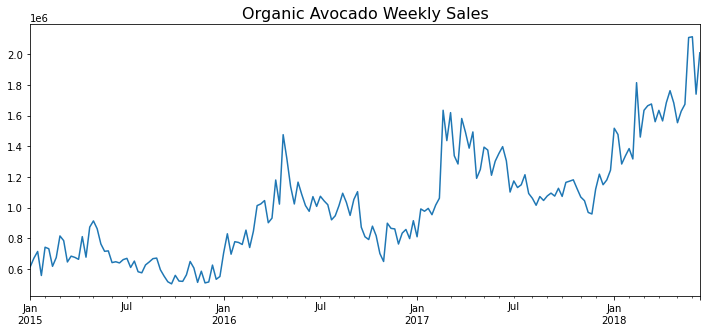

In [15]:
# Plot the data (train series)
train.plot(figsize=(12,5), legend=None)
plt.title('Organic Avocado Weekly Sales', fontsize=16)
plt.xlabel(None);

**Overview:**
- There appears to be an overall increasing trend.
- There appears to be differences in the variance over time.
- There may be some seasonality.
- There may be some outliers.

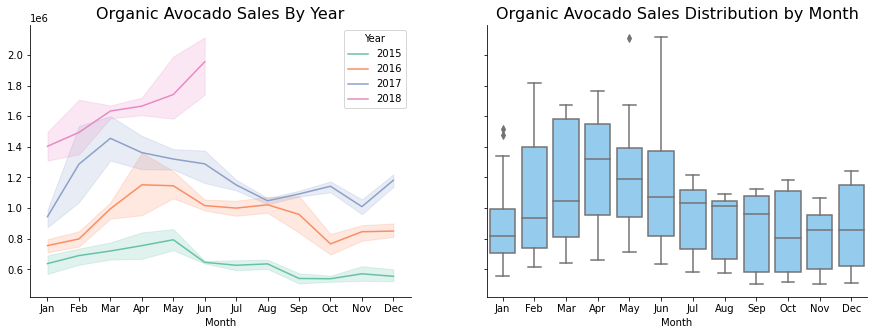

In [16]:
# Plot data by monthly basis
# Use line chart and box plot
train['Month'] = train.index.strftime('%b')
train['Year'] = train.index.year

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.lineplot(data=train,
             hue='Year',
             x='Month',
             y='y',
             palette='Set2',
             ax=ax[0])
ax[0].set_title('Organic Avocado Sales By Year', fontsize=16)
ax[0].set_ylabel(None)

sns.boxplot(data=train,
            x='Month',
            y='y',
            color='lightskyblue',
            ax=ax[1])
ax[1].set_title('Organic Avocado Sales Distribution by Month', fontsize=16)
ax[1].set_ylabel(None)

sns.despine()
train.drop(['Year', 'Month'], axis=1, inplace=True)

There seems to be a peak every year around March, April, and May. Outliers seems not to be significant.

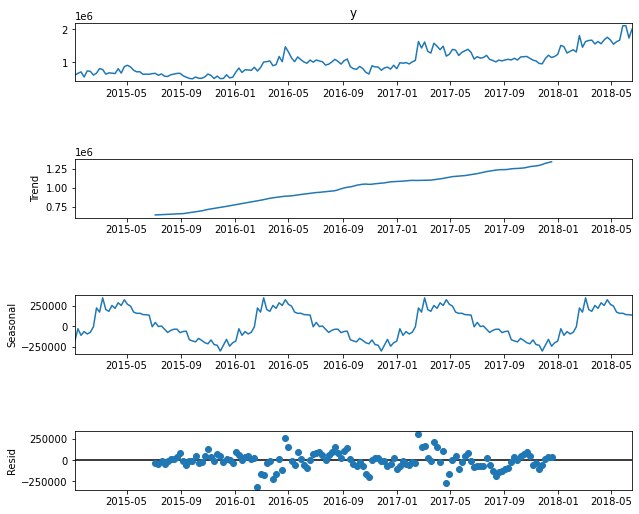

In [17]:
# Another way to decompose the series characteristics
decomposition = seasonal_decompose(train['y'])
fig = decomposition.plot()
fig.set_size_inches(10,8)

## Forecasting
### Exponential Smoothing

Since the series has seasonality, let's go ahead and apply triple smoothing.

In [18]:
# Try multiple combination to find a model that has the lowest RSME
# Try different number of weeks for annual seasonality

trend = ['additive', 'multiplicative']
seasonality = ['additive', 'multiplicative']
periods = range(52, 56)

lowest_rmse = None
lowest_rmse_model = None

for model in list(itertools.product(trend, seasonality, periods)):
    # Modeling
    fcast_model = ExponentialSmoothing(train['y'],
                                       trend=model[0],
                                       seasonal=model[1],
                                       seasonal_periods=model[2]).fit()
    y_fcast = fcast_model.forecast(len(test)).rename('y_fcast')
    
    # RSME
    rmse = np.sqrt(np.mean((test['y'] - y_fcast)**2))
    
    # Store results
    current_rmse = rmse
        
    # Set baseline for rmse
    if lowest_rmse == None:
        lowest_rmse = rmse
        
    # Compare results
    if current_rmse <= lowest_rmse:
        lowest_rmse = current_rmse
        lowest_rmse_model = model      
    print('{} trend, {} seasonality, {} week frequency - RSME: {}'.format(model[0], model[1], model[2], rmse))
    
print('--------------------------------------------------------------------------------------')
print('Model that has the lowest RSME:')
print('{} trend, {} seasonality, {} week frequency - RSME: {}'.format(lowest_rmse_model[0], lowest_rmse_model[1],
                                                                      lowest_rmse_model[2], lowest_rmse))

additive trend, additive seasonality, 52 week frequency - RSME: 438898.5984885837
additive trend, additive seasonality, 53 week frequency - RSME: 370625.5208113973
additive trend, additive seasonality, 54 week frequency - RSME: 334082.60656625556
additive trend, additive seasonality, 55 week frequency - RSME: 444157.8023230054
additive trend, multiplicative seasonality, 52 week frequency - RSME: 190158.2464919983
additive trend, multiplicative seasonality, 53 week frequency - RSME: 131606.55613004172
additive trend, multiplicative seasonality, 54 week frequency - RSME: 155153.19403314134
additive trend, multiplicative seasonality, 55 week frequency - RSME: 313805.9526185713
multiplicative trend, additive seasonality, 52 week frequency - RSME: 591256.1442751811
multiplicative trend, additive seasonality, 53 week frequency - RSME: 520250.1764916206
multiplicative trend, additive seasonality, 54 week frequency - RSME: 470981.04240176076
multiplicative trend, additive seasonality, 55 week 

I will try 53-week and 54-week periods because their RSMEs are not much different.

In [19]:
def error_metrics(y_fcast, y_test):
    """
    Return mean absolute percentage error (MAPE)
           mean percentage error (MPE)
           mean absolute error (MAE)
           root mean square error (RMSE)
           
    """
    print(f'MAPE: {np.mean(np.abs((y_test - y_fcast)/y_test))*100}')
    print(f'MPE:  {np.mean((y_test - y_fcast)/y_test)*100}')
    print(f'MAE:  {np.mean(np.abs(y_test - y_fcast))*100}')
    print(f'RMSE: {np.sqrt(np.mean((y_test - y_fcast)**2))}')
    

def exp_smoothing(y_train,
                  y_test,
                  trend=None,
                  seasonal=None,
                  period=None,
                  freq=None,
                  plot=False,
                  figsize=None):
    """
    Forecast using Holt-Winters exponential smoothing.
    Return a graph and error metrics.
    """
    # Modeling
    fcast_model = ExponentialSmoothing(y_train,
                                       trend=trend,
                                       seasonal=seasonal,
                                       seasonal_periods=period).fit()
    y_est = pd.DataFrame(fcast_model.fittedvalues).rename(columns={0:'y_fitted'}) # In-sample fit
    y_fcast = fcast_model.forecast(len(y_test)).rename('y_fcast') # Out-of-sample fit
    
    # Plot Series
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        ax.set_title('Observed, Fitted, and Forecasted Series\nTriple Exponential Smoothing',
                     fontsize=16)
        ax.set_ylabel('Organic Avocado Weekly Sales')
        ax.plot(y_train,
                label='In-sample data',
                linestyle='-')
        ax.plot(y_test,
                label='Held-out data',
                linestyle='-')
        ax.plot(y_est,
                label='Fitted values',
                linestyle='--',
                color='g')
        ax.plot(y_fcast,
                label='Forecasts',
                linestyle='--',
                color='k')
        ax.legend(loc='best')
        plt.xticks(rotation = 45)
        plt.show(block = False)
        plt.close()
    
    # Print error metrics
    print('-----------------------------')
    if seasonal != None:
        print('{} trend, {} seasonality, {} {} frequency'.format(trend, seasonal, period, freq))
    error_metrics(y_fcast=y_fcast, y_test=y_test)
    print(f'AIC:  {fcast_model.aic}')
    print(f'BIC:  {fcast_model.bic}')

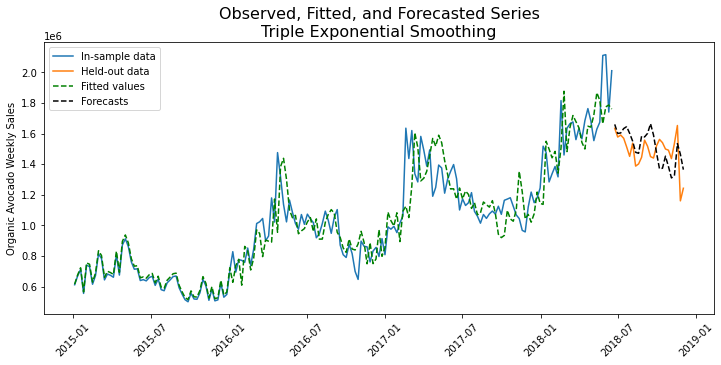

-----------------------------
additive trend, multiplicative seasonality, 53 week frequency
MAPE: 7.6261727322483885
MPE:  -2.128966663891398
MAE:  10944425.606515003
RMSE: 131606.55613004172
AIC:  4411.319055738252
BIC:  4593.633386520404


In [20]:
exp_smoothing(train['y'],
              test['y'],
              trend='additive',
              seasonal='multiplicative',
              period=53,
              freq='week',
              plot=True,
              figsize=(12,5))

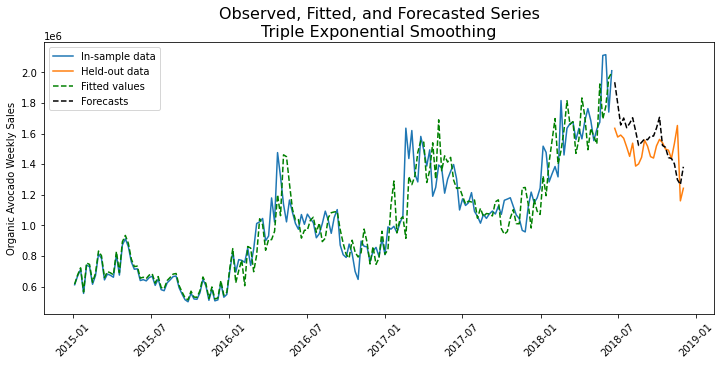

-----------------------------
additive trend, multiplicative seasonality, 54 week frequency
MAPE: 8.5795807921079
MPE:  -5.705947201242931
MAE:  12804559.72378634
RMSE: 155153.19403314134
AIC:  4401.791958569102
BIC:  4587.3047863825195


In [21]:
exp_smoothing(train['y'],
              test['y'],
              trend='additive',
              seasonal='multiplicative',
              period=54,
              freq='week',
              plot=True,
              figsize=(12,5))

### SARIMA
#### Stationarization

In [22]:
def test_stationarity(y, title, window , figsize=(12,5)):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    # Determing rolling statistics
    rolmean = y.rolling(window=window, center=False).mean()
    rolstd = y.rolling(window=window, center=False).std()
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=figsize)
    orig = plt.plot(y,
                    label='Original')
    mean = plt.plot(rolmean,
                    label='Rolling Mean',
                    color='r')
    std = plt.plot(rolstd,
                   label='Rolling Std',
                   color='orange')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for ' + title, fontsize=16)
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()

    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic',
                                'p-value',
                                '# Lags Used',
                                'Number of Observations Used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k]=v
    print(dfoutput)

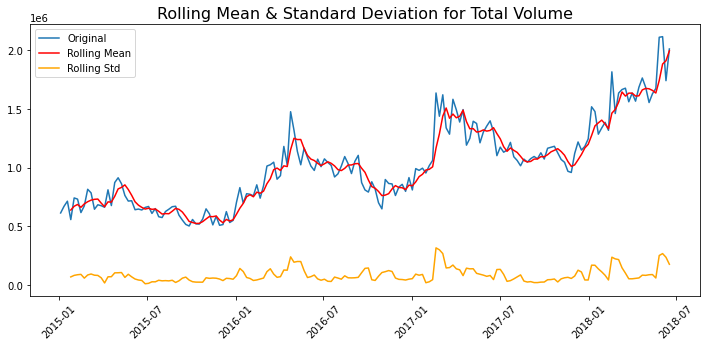

Results of Dickey-Fuller Test:
Test Statistic                  -0.056566
p-value                          0.953597
# Lags Used                      7.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64


In [23]:
test_stationarity(train['y'],
                  'Total Volume',
                  window=4)

Obviously this is not a stationary series.

In [24]:
def plot_general(y,
                 title='title',
                 lags=None,
                 figsize=(12,8)):
    """
    Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    Source: https://github.com/jeffrey-yau/Pearson-TSA-Training-Beginner/blob/master/1_Intro_and_Overview.ipynb
    """
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_xlabel(None)
    ts_ax.set_title(title)
    
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()

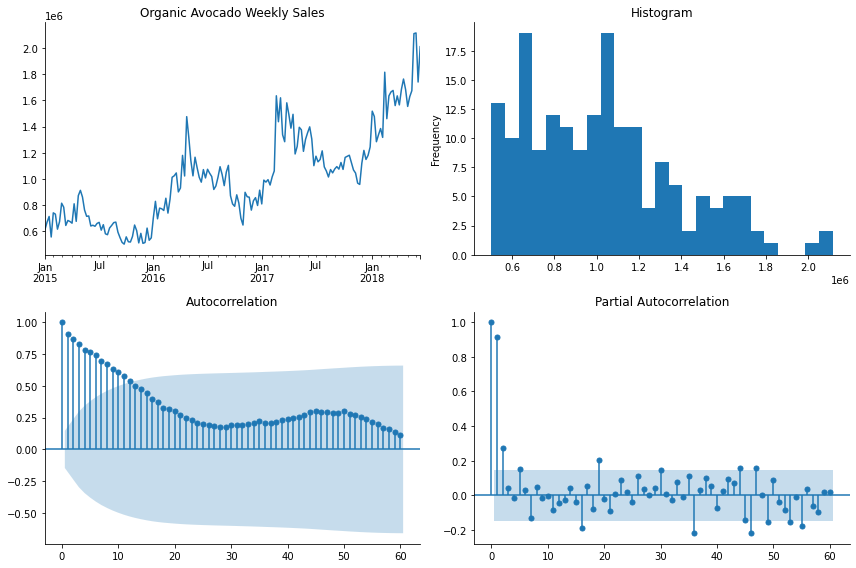

In [25]:
plot_general(train['y'],
             title='Organic Avocado Weekly Sales',
             lags=60,
             figsize=(12,8))

The ACF does not help much with identifying the seasonality.

In [26]:
# Let's go ahead and apply a log transformation
# Then take first difference
def plot_diff(y,
              title='title',
              diff=1,
              log=True,
              test=True,
              window=None,
              lags=None):
    if log:
        y = np.log(y)
        y_diff = y.diff(diff)
        y_diff.dropna(inplace=True)
    else:
        y_diff = y.diff(diff)
        y_diff.dropna(inplace=True)
    plot_general(y_diff, title, lags)
    if test:
        test_stationarity(y_diff, title , window)
    else:
        pass

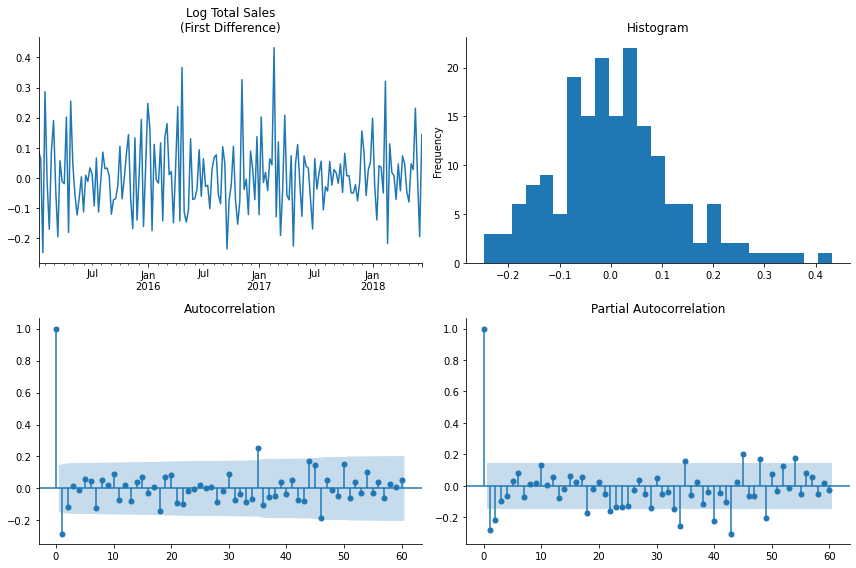

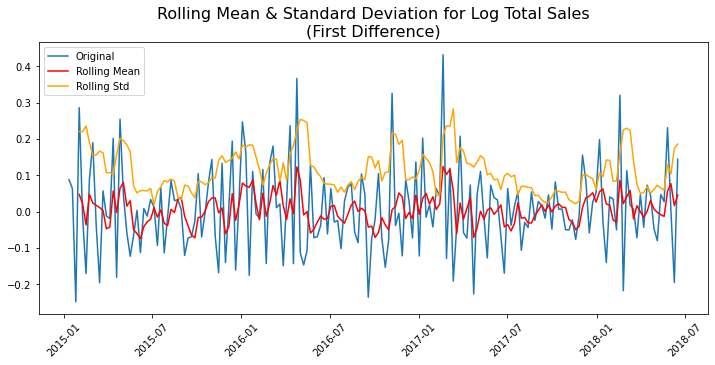

Results of Dickey-Fuller Test:
Test Statistic                -1.318514e+01
p-value                        1.174325e-24
# Lags Used                    1.000000e+00
Number of Observations Used    1.780000e+02
Critical Value (1%)           -3.467632e+00
Critical Value (5%)           -2.877918e+00
Critical Value (10%)          -2.575501e+00
dtype: float64


In [27]:
plot_diff(train['y'],
          window=4,
          lags=60,
          title='Log Total Sales\n(First Difference)')

- The series is stationary.
- The series appears slightly overdifferenced (the ACF displays a sharp cutoff and the lag-1 is negative).
- The ACF cuts off at lag 1

This suggests: (p, d, q) = (0, 1, 1)

Based on the triple smoothing result, let's try 53-week and 54-week periods for the seasonal difference.

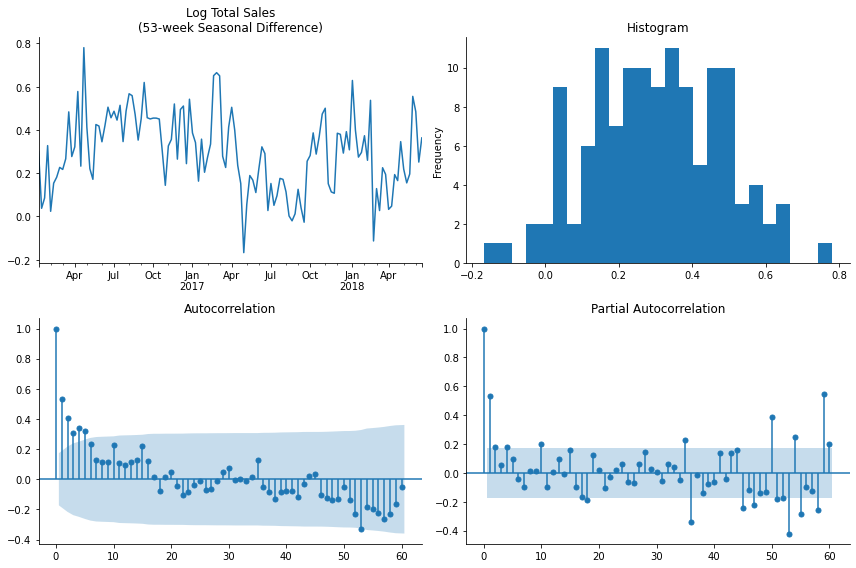

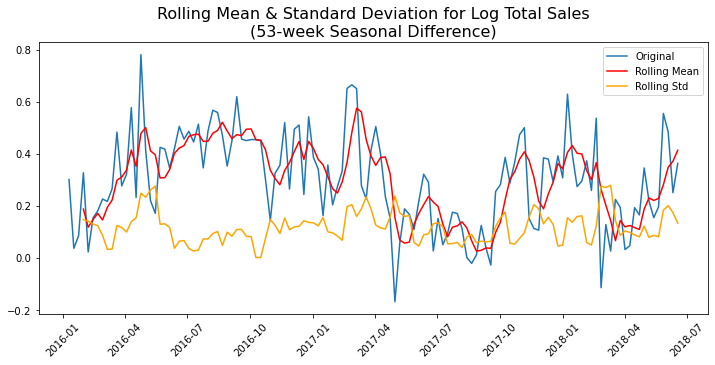

Results of Dickey-Fuller Test:
Test Statistic                  -3.053853
p-value                          0.030162
# Lags Used                      3.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


In [28]:
plot_diff(train['y'],
          window=4,
          lags=60,
          diff=53,
          title='Log Total Sales\n(53-week Seasonal Difference)')

- The series is stationary.
- The autocorrelation is positive.
- The ACF has spikes while the PACF cuts off right after lag 1.

This suggests: (P, D, Q) = (1, 1, 0)

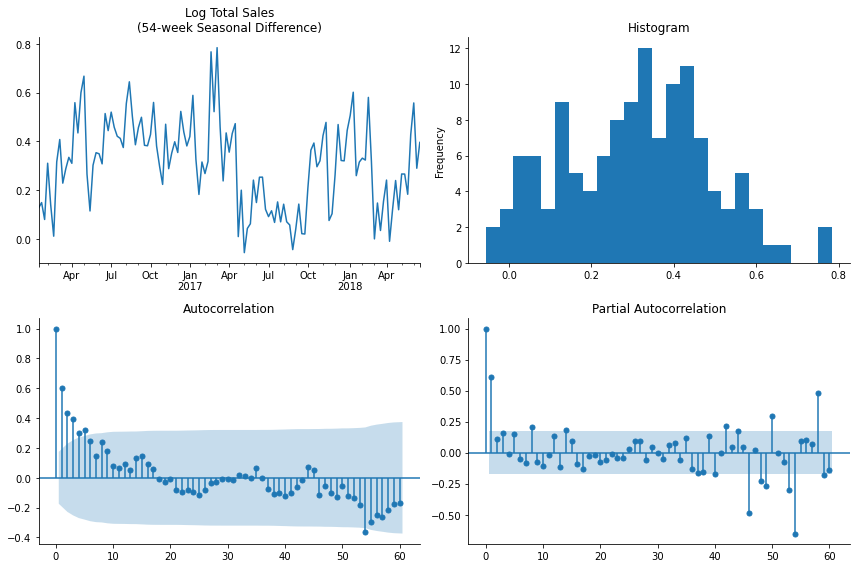

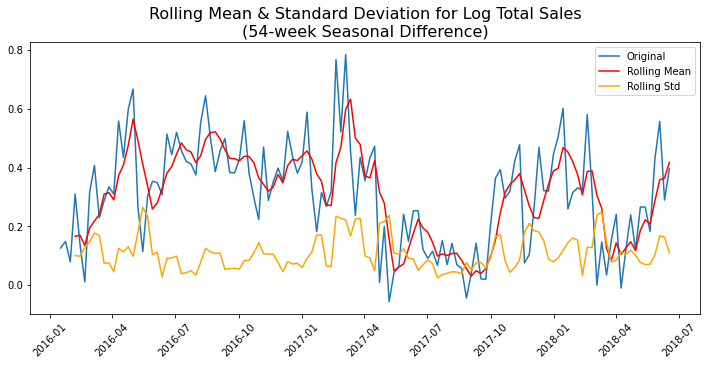

Results of Dickey-Fuller Test:
Test Statistic                  -5.573418
p-value                          0.000001
# Lags Used                      0.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
Critical Value (10%)            -2.579156
dtype: float64


In [29]:
plot_diff(train['y'],
          window=4,
          lags=60,
          diff=54,
          title='Log Total Sales\n(54-week Seasonal Difference)')

- The series is stationary.
- The autocorrelation is positive.
- The ACF has spikes while the PACF cuts off right after lag 1.

This suggests: (P, D, Q) = (1, 1, 0)

In [30]:
# Log transformation
log_train = np.log(train['y'])
log_test = np.log(test['y'])

#### Model Selection

In [31]:
# Search over few models to find a model that has the lowest AIC/BIC
mdl_index = []
mdl_aic = []
mdl_bic = []

p = range(0,2)
d = range(0,2)
q = range(0,2)
P = range(0,2)
D = range(1,2)
Q = range(0,2)
S = range(53,55)

# Set variables to populate
#lowest_aic = None
#lowest_parm_aic = None
#lowest_param_seasonal_aic = None

#lowest_bic = None
#lowest_parm_bic = None
#lowest_param_seasonal_bic = None

# GridSearch the hyperparameters of p, d, q and P, D, Q, S
for param in list(itertools.product(p, d, q)):
    for param_seasonal in list(itertools.product(P, D, Q, S)):
        mdl = sm.tsa.statespace.SARIMAX(log_train,
                                        order=param,
                                        seasonal_order=param_seasonal)
        results = mdl.fit()      
        # Store results
        current_aic = results.aic
        current_bic = results.bic
        mdl_index.append('SARIMA{}x{}'.format(param, param_seasonal))
        mdl_aic.append(current_aic)
        mdl_bic.append(current_bic)
            
        # Set baseline for aic
        #if lowest_aic == None:
            #lowest_aic = results.aic
        # Set baseline for bic
        #if lowest_bic == None:
            #lowest_bic = results.bic
        # Compare results
        #if current_aic <= lowest_aic:
            #lowest_aic = current_aic
            #lowest_parm_aic = param
            #lowest_param_seasonal_aic = param_seasonal
        #if current_bic <= lowest_bic:
            #lowest_bic = current_bic
            #lowest_parm_bic = param
            #lowest_param_seasonal_bic = param_seasonal            
        #print('SARIMA{}x{} - AIC:{} - BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
        
#print('--------------------------------------------------------------------------------------')
#print('Model that has the lowest AIC: SARIMA{}x{} - AIC:{}'.format(lowest_parm_aic, lowest_param_seasonal_aic, lowest_aic))
#print('Model that has the lowest BIC: SARIMA{}x{} - BIC:{}'.format(lowest_parm_bic, lowest_param_seasonal_bic, lowest_bic))

In [32]:
print(pd.DataFrame(index=mdl_index, data=mdl_aic).rename(columns={0:'AIC'}).sort_values(by='AIC').head(5))
print('-----------------------------------------')
print(pd.DataFrame(index=mdl_index, data=mdl_bic).rename(columns={0:'BIC'}).sort_values(by='BIC').head(5))

                                      AIC
SARIMA(1, 1, 1)x(0, 1, 1, 54) -146.285635
SARIMA(1, 1, 1)x(1, 1, 0, 54) -145.193120
SARIMA(1, 1, 1)x(1, 1, 1, 54) -144.301477
SARIMA(0, 1, 1)x(0, 1, 1, 54) -142.806055
SARIMA(0, 1, 1)x(1, 1, 0, 54) -141.026672
-----------------------------------------
                                      BIC
SARIMA(1, 1, 1)x(0, 1, 1, 54) -134.940507
SARIMA(0, 1, 1)x(0, 1, 1, 54) -134.297210
SARIMA(1, 1, 1)x(1, 1, 0, 54) -133.847993
SARIMA(0, 1, 1)x(1, 1, 0, 54) -132.517826
SARIMA(1, 1, 1)x(1, 1, 1, 54) -130.120067


- SARIMA(1, 1, 1)x(0, 1, 1, 54) appears to be the best model.
- SARIMA(0, 1, 1)x(0, 1, 1, 54) has the common form of a seasonal model and it has the second highest BIC.

We will try both of these models.

#### Modeling

In [33]:
class Sarima:
    def __init__(self,
                 y_train,
                 y_test,
                 order,
                 seasonal_order):
        self.y_train = y_train
        self.y_test = y_test
        self.order = order
        self.seasonal_order = seasonal_order
        
        # Modeling
        self._model = sm.tsa.statespace.SARIMAX(self.y_train,
                                                order=self.order,
                                                seasonal_order=self.seasonal_order)
        self._results = self._model.fit()
        
        # Construct in-sample fit
        self.y_est = self._results.get_prediction()
        self.y_est_mean = self.y_est.predicted_mean
        self.y_est_ci = self.y_est.conf_int(alpha=0.05)
    
        # Construct out-of-sample forecasts
        self.y_fcast = self._results.get_forecast(steps=len(y_test)).summary_frame()
        self.y_fcast.set_index(y_test.index, inplace=True)
        
    def results(self):
        print(self._results.summary())
    
    def diagnostics(self):
        print(self._results.plot_diagnostics(figsize=(15,8)))
        
    def plot(self):
        # Transform forecast to original scale
        inv_y_fcast = np.exp(self.y_fcast)
        inv_y_est_mean = np.exp(self.y_est_mean)
        inv_y_est_ci = np.exp(self.y_est_ci)
        inv_y_train = np.exp(self.y_train)
        inv_y_test = np.exp(self.y_test)
        
        # Plot the series
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
        start_index = self.order[1] + self.seasonal_order[3]
        ax.set_title('Observed, Fitted, and Forecasted Series\nSARIMA{}x{}'.format(self.order, self.seasonal_order),
                     fontsize=16)
        ax.set_ylabel('Organic Avocado Weekly Sales')
        ax.plot(inv_y_train,
                label='In-sample data',
                linestyle='-')
        ax.plot(inv_y_test,
                label='Held-out data',
                linestyle='-')
        ax.plot(inv_y_est_mean[start_index :],
                label='Fitted values',
                linestyle='--',
                color='g')
        ax.plot(inv_y_fcast['mean'],
                label='Forecasts',
                linestyle='--',
                color='k')
        
        # Plot confidence intervals
        ax.fill_between(inv_y_est_mean[start_index :].index,
                        inv_y_est_ci.iloc[start_index :, 0],
                        inv_y_est_ci.iloc[start_index :, 1],
                        color='g', alpha=0.05)
        ax.fill_between(inv_y_fcast.index,
                       inv_y_fcast['mean_ci_lower'],
                       inv_y_fcast['mean_ci_upper'], 
                       color='k',
                        alpha=0.05)
        
        ax.legend(loc='upper left')
        plt.xticks(rotation = 45)
        plt.show(block = False)
        plt.close()
        
        # Return error metrics
        error_metrics(inv_y_fcast['mean'], inv_y_test)

#### SARIMA(1, 1, 1)x(0, 1, 1, 54)

In [34]:
Sarima(y_train=log_train,
       y_test=log_test,
       order=(1, 1, 1),
       seasonal_order=(0, 1, 1, 54)).results()

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  181
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 54)   Log Likelihood                  77.143
Date:                            Sun, 03 Jan 2021   AIC                           -146.286
Time:                                    11:09:26   BIC                           -134.941
Sample:                                01-04-2015   HQIC                          -141.676
                                     - 06-17-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3506      0.142      2.462      0.014       0.071       0.630
ma.L1         -0.8385      0.075   

Figure(1080x576)


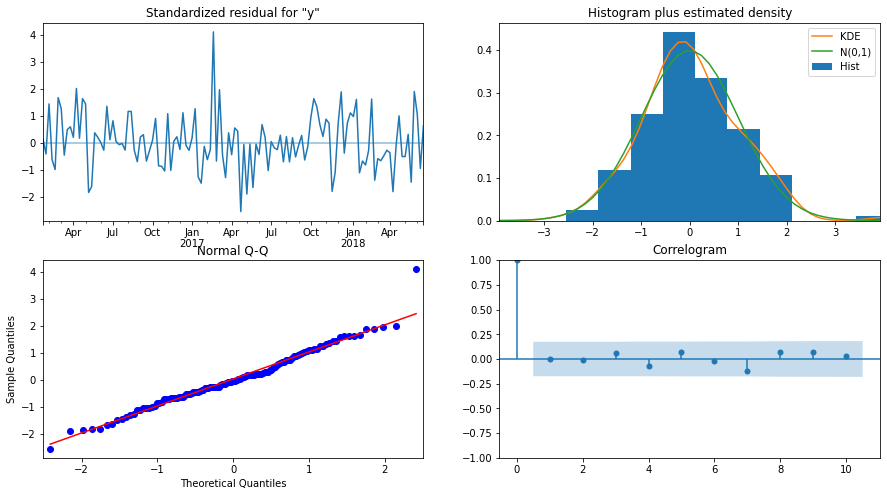

In [35]:
Sarima(y_train=log_train,
       y_test=log_test,
       order=(1, 1, 1),
       seasonal_order=(0, 1, 1, 54)).diagnostics()

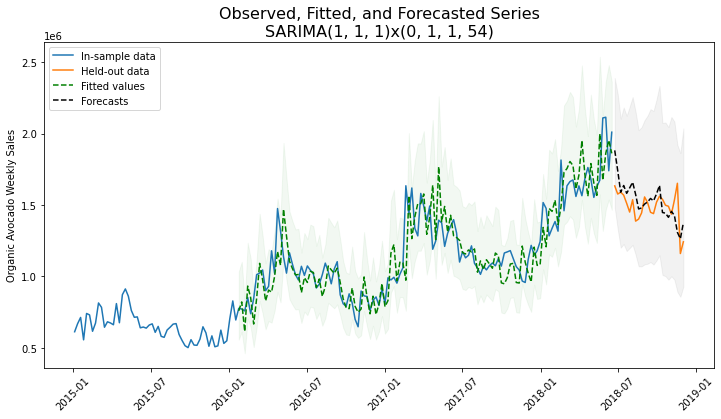

MAPE: 6.827064824628626
MPE:  -3.0004839850839082
MAE:  10171574.448227953
RMSE: 127108.04375156338


In [36]:
Sarima(y_train=log_train,
       y_test=log_test,
       order=(1, 1, 1),
       seasonal_order=(0, 1, 1, 54)).plot()

#### SARIMA(0, 1, 1)x(0, 1, 1, 54)

In [37]:
Sarima(y_train=log_train,
       y_test=log_test,
       order=(0, 1, 1),
       seasonal_order=(0, 1, 1, 54)).results()

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  181
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 54)   Log Likelihood                  74.403
Date:                            Sun, 03 Jan 2021   AIC                           -142.806
Time:                                    11:09:40   BIC                           -134.297
Sample:                                01-04-2015   HQIC                          -139.349
                                     - 06-17-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5848      0.079     -7.381      0.000      -0.740      -0.429
ma.S.L54      -0.6270      0.215   

Figure(1080x576)


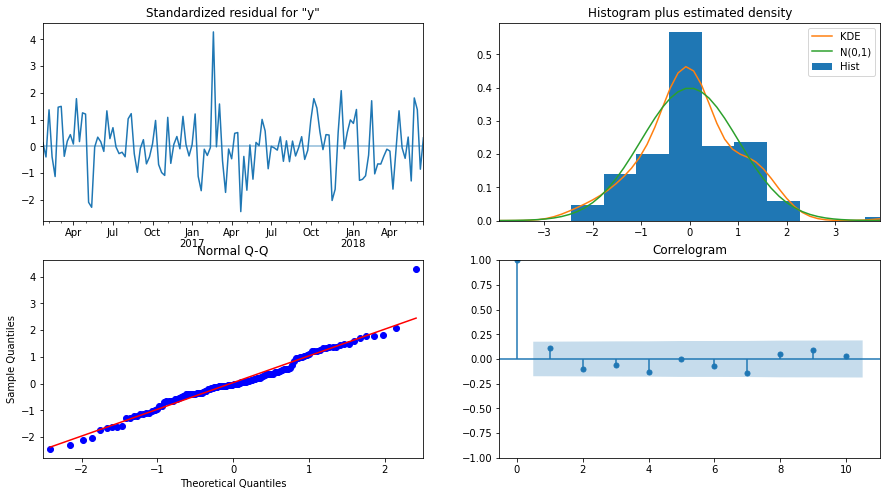

In [38]:
Sarima(y_train=log_train,
       y_test=log_test,
       order=(0, 1, 1),
       seasonal_order=(0, 1, 1, 54)).diagnostics()

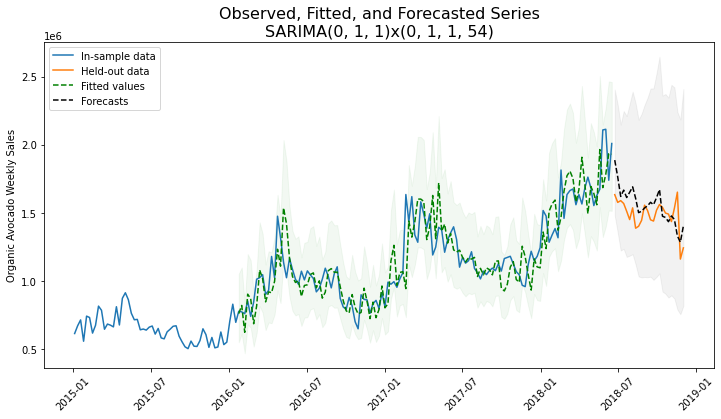

MAPE: 7.88721890535521
MPE:  -4.854959075003457
MAE:  11684456.796120973
RMSE: 138819.46533337093


In [39]:
Sarima(y_train=log_train,
       y_test=log_test,
       order=(0, 1, 1),
       seasonal_order=(0, 1, 1, 54)).plot()

### Facebook Prophet

In [44]:
df = train.reset_index()
df.rename(columns={'date':'ds'}, inplace=True)

In [45]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(len(test), freq='W')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


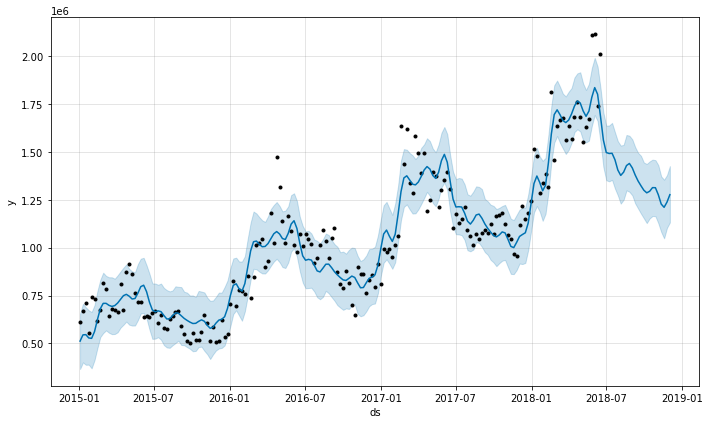

In [46]:
fig1 = m.plot(forecast)

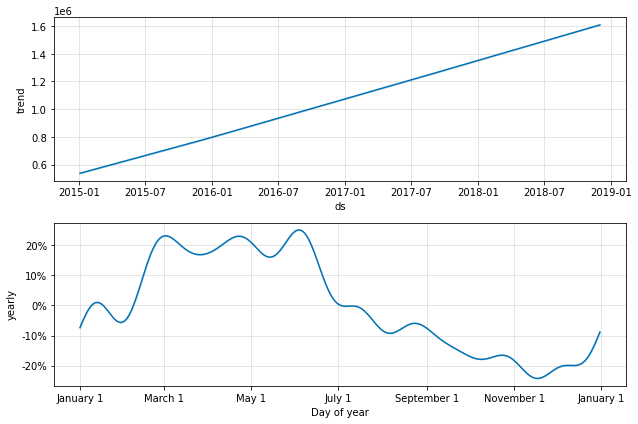

In [47]:
fig2 = m.plot_components(forecast)

In [48]:
error_metrics(y_fcast = forecast[-len(test):]['yhat'].values,
              y_test = test['y'].values)

MAPE: 8.879803700271905
MPE:  7.890448839109982
MAE:  13514397.691569302
RMSE: 169932.0614506286


## Conclusion

| Model | MAPE | MPE | MAE | RMSE |
| :-----|------|-----|-----|------|
|Triple Smoothing (53 weeks) | 7.62617 | -2.12897 | 10944425.60652 | 131606.55613 |
|Triple Smoothing (54 weeks) | 8.57958 | -5.70595 | 12804559.72379 | 155153.19403 |
|SARIMA(1, 1, 1)x(0, 1, 1, 54) | 6.82706 | -3.00048 | 10171574.44823 | 127108.04375 |
|SARIMA(0, 1, 1)x(0, 1, 1, 54) | 7.88722 | -4.85496 | 11684456.79612 | 138819.46533 |
|Facebook Prophet | 8.87980 | 7.89045 | 13514397.69157 | 169932.06145 |

Based on this chart, SARIMA(1, 1, 1)x(0, 1, 1, 54) is the best model.